In [2]:
%matplotlib inline
import sys
sys.path.append("../")
import cv2
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import numpy as np
import quat_math as qm
import torch
import seaborn as sns
from torch.autograd import Variable
from generic_pose.utils import to_np, to_var

import warnings; warnings.simplefilter('ignore')
pylab.rcParams['figure.figsize'] = 20, 12

In [3]:
from vanilla_segmentation.data_controller import SegDataset
from vanilla_segmentation.segnet import SegNet as segnet

dataset_root = '/home/bokorn/src/DenseFusion/datasets/ycb/YCB_Video_Dataset'
with open('../datasets/ycb/YCB_Video_Dataset/image_sets/classes.txt') as f:
    classes = f.read().split()
classes.insert(0, 'background')

In [4]:
def torch2Img(img, unnormalize = True):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_img = to_np(img)
    if len(disp_img.shape) == 4:
        disp_img = disp_img[0]
    disp_img = disp_img.transpose((1,2,0))
    if(unnormalize):
        disp_img = disp_img * std + mean
    if(disp_img.shape[2]==1):
        disp_img = disp_img[:,:,0]
    return disp_img

In [5]:
def imshowTorch(img, axis = False, unnormalize=True, cmap=None):
    if not axis:
        plt.axis('off')
    if(cmap is not None):
        unnormalize = False
    disp_img = torch2Img(img, unnormalize)
    plt.imshow(disp_img.astype(np.uint8), cmap = cmap)
    plt.show()

In [6]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def imshowSeg(img, seg, colors=None, classes = classes, filter_seg=True):
    plt.subplot(1,2,1)
    plt.axis('off')
    disp_img = torch2Img(img, True)
    plt.imshow(disp_img.astype(np.uint8))
    plt.subplot(1,2,2)
    plt.axis('off')
    seg_img = torch2Img(torch.argmax(seg, dim=1), False)
    ids,cnts = np.unique(seg_img, return_counts=True)
    if(filter_seg):
        ids = ids[cnts>0.01*seg_img.size]
        seg_img = torch2Img(torch.argmax(seg[:,ids,:,:], dim=1), False)
    if(colors is None):
        colors = sns.color_palette(n_colors=len(ids)-1)
        colors.insert(0, (0.,0.,0.))
        #for j in range(22):
        #    c_idx = np.argwhere(ids==j)
        #    if(j == 0 or len(c_idx)==0):
        #        colors.append((0.,0.,0.))
        #    else:
        #        colors.append(seg_colors[c_idx.flat[0]])
    legend_elements = [Patch(facecolor=clr, edgecolor=None,
                             label=classes[j]) for j, clr in zip(ids, colors)]
    
    plt.imshow(seg_img.astype(np.uint8))
    plt.imshow(seg_img.astype(np.uint8), 
               cmap = mpl.colors.ListedColormap(colors),
               norm = mpl.colors.BoundaryNorm(range(23), 23))
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

In [34]:
#checkpoint_path = '/home/bokorn/src/DenseFusion/vanilla_segmentation/trained_models/model_9_0.13448504739743838.pth'
checkpoint_path = '/home/bokorn/src/DenseFusion/vanilla_segmentation/trained_models/model_current.pth'
batch_size = 1
workers = 0

dataset = SegDataset(dataset_root, '/home/bokorn/src/DenseFusion/datasets/ycb/dataset_config/train_data_list.txt', True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=int(workers))
test_dataset = SegDataset(dataset_root, '/home/bokorn/src/DenseFusion/datasets/ycb/dataset_config/test_data_list.txt', False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=int(workers))

model = segnet()
model = model.cuda()
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.eval();

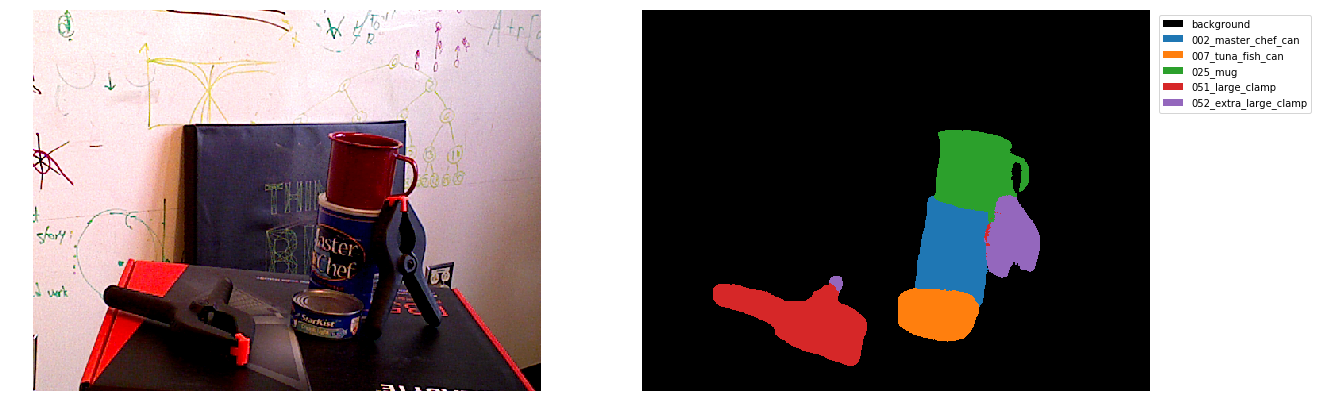

In [33]:
for i, data in enumerate(test_dataloader, 0):
    rgb = Variable(data[0]).cuda()
    semantic = model(rgb)
    imshowSeg(rgb, semantic)
    break

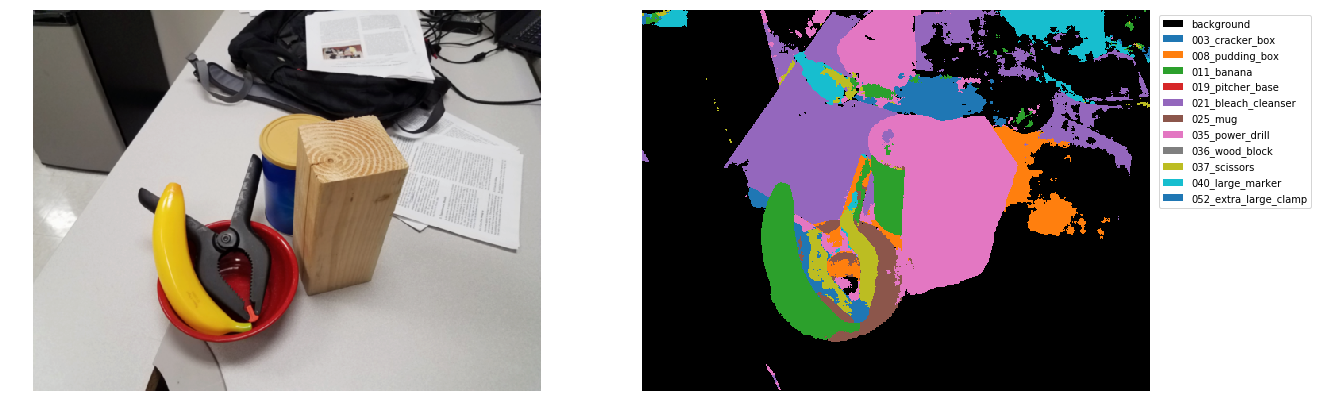

In [49]:
rgb = cv2.imread('../vanilla_segmentation/test.jpg')
rgb = cv2.GaussianBlur(rgb,(21,21),0)
rgb = cv2.resize(rgb, (640, 480))
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb = np.transpose(rgb, (2, 0, 1))
rgb = dataset.norm(torch.from_numpy(rgb.astype(np.float32)))
rgb = Variable(rgb).unsqueeze(0).cuda()
semantic = model(rgb)
imshowSeg(rgb, semantic)